In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import Adam

import sys
sys.path.append('../module/')

from util import moving_average
import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
dt = 0.005
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [24]:
#safe learning
l = 0.5
step = 40000
episode_step = int(200 * 0.05 / dt)
time_mode = False
a = agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, loss_graph=0, time_mode=time_mode, pure=1)

Training for 40000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 53s 5ms/step - reward: -0.7207
5 episodes - episode_reward: -1441.415 [-1868.692, -522.009] - loss: 0.015 - mean_absolute_error: 0.122 - mean_q: -2.083

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 61s 6ms/step - reward: -0.5553
5 episodes - episode_reward: -1110.502 [-1703.150, -399.598] - loss: 0.024 - mean_absolute_error: 0.154 - mean_q: -3.887

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 62s 6ms/step - reward: -0.6425
5 episodes - episode_reward: -1285.060 [-1813.337, -720.846] - loss: 0.036 - mean_absolute_error: 0.187 - mean_q: -5.478

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 63s 6ms/step - reward: -0.6869
done, took 238.707 seconds


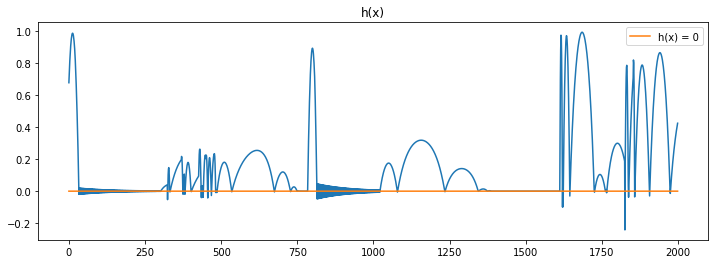

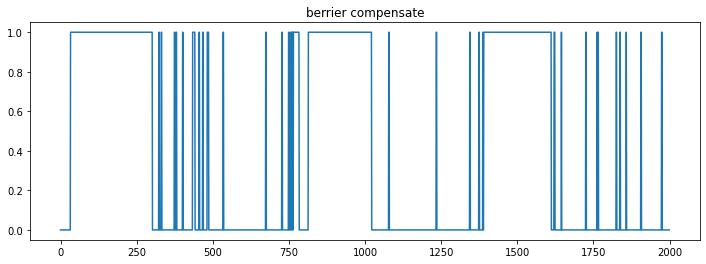

In [25]:
# first episode log
episode_step = int(200 * 0.05 / dt)
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[:episode_step,0])
plt.plot(range(episode_step), np.zeros(episode_step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[:episode_step,1])
plt.show()

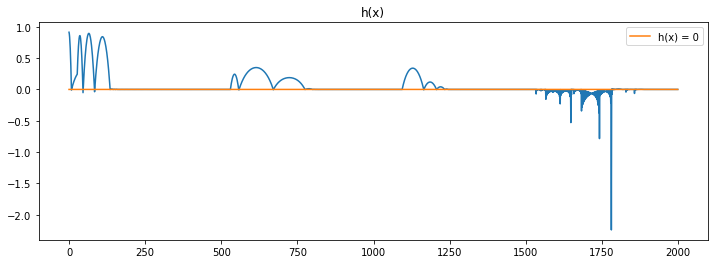

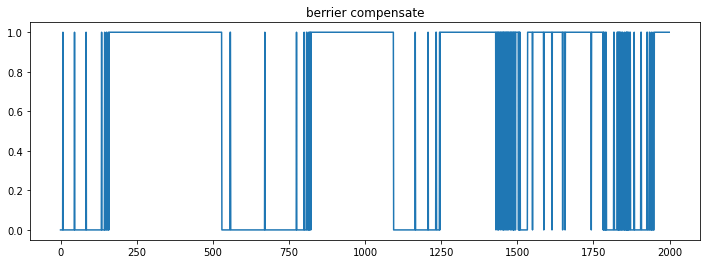

In [26]:
# log per episode
interval = 10
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1), 0])
plt.plot(range(episode_step), np.zeros(episode_step ,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1),1])
plt.show()

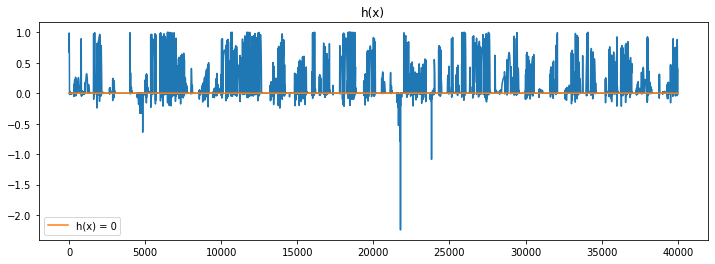

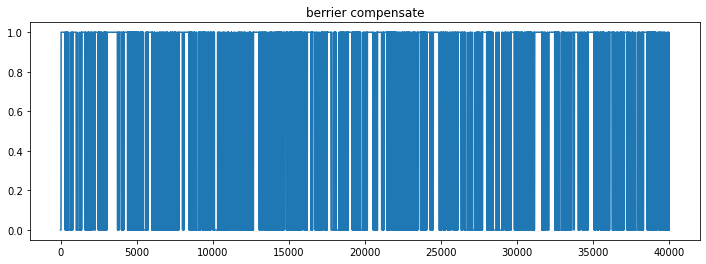

In [27]:
# log throughout learning
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(step), a.cbf_log[:,0])
plt.plot(range(step), np.zeros(step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(step), a.cbf_log[:,1])
plt.show()

In [28]:
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.test(env, lam=l, visualize=0, nb_max_episode_steps=episode_step, action_view=0, time_mode=time_mode, pure=1)

Testing for 1 episodes ...
Episode 1: reward: -1286.306, steps: 2000


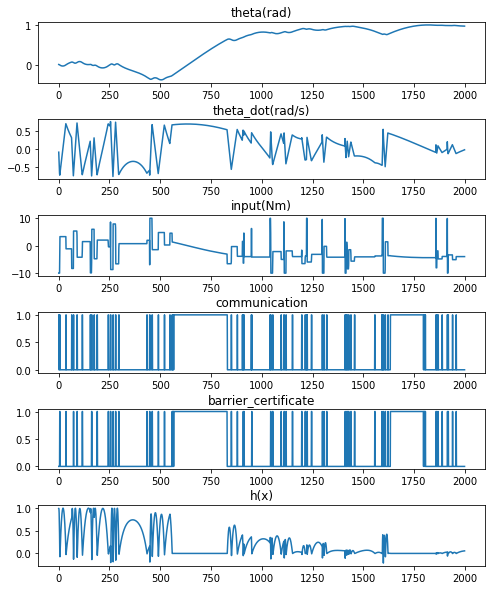

In [29]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'communication', 'barrier_certificate', 'h(x)'] 
history = a.data_log[0]
x_axis = range(episode_step)
plt.figure(figsize=(8,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(6):
    data = history[:,i]
    plt.subplot(6,1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [35]:
a.save_weights('../learned_models_safe/3000000_e2000_l05_pure.h5')

[WARNING] ../learned_models_safe/3000000_e2000_l05_pure_actor.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
[WARNING] ../learned_models_safe/3000000_e2000_l05_pure_critic.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


(array([ 949.,   11.,    0.,    0.,    4.,   12.,    5.,    3.,    3.,
        1013.]),
 array([-3.14158925e+00, -2.51327466e+00, -1.88496007e+00, -1.25664549e+00,
        -6.28330898e-01, -1.63091561e-05,  6.28298279e-01,  1.25661287e+00,
         1.88492746e+00,  2.51324205e+00,  3.14155663e+00]),
 <a list of 10 Patch objects>)

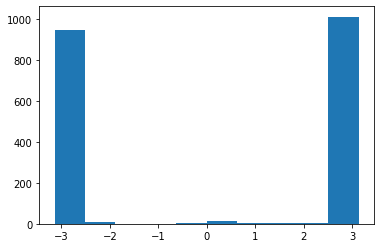

In [11]:
plt.hist(history[:,0])

In [22]:
import csv

with open("../learning_log_pure.csv", "w") as f:
    writer = csv.writer(f)
    for row in a.cbf_log:
        writer.writerow(row)

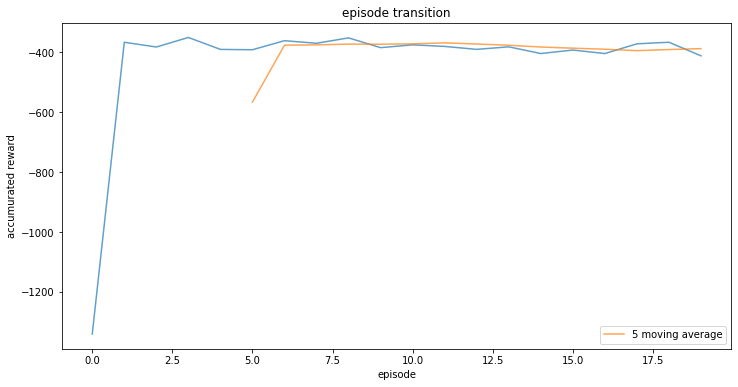

In [12]:
l = 5
plt.figure(figsize=(12,6))
ma = moving_average(a.episode_rewards, l)
plt.plot(range(len(a.episode_rewards)), a.episode_rewards, alpha=0.7)
plt.plot(range(l, len(a.episode_rewards)), ma, label=f'{l} moving average', alpha=0.7)
plt.xlabel('episode')
plt.ylabel('accumurated reward')
plt.title('episode transition')
plt.legend()
plt.show()

In [44]:
rewards = np.array(a.episode_rewards)
import csv

with open("../episode_rewards_pure.csv", "w") as f:
    writer = csv.writer(f)
    for row in rewards:
        writer.writerow([row])

(array([1982.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         18.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <a list of 10 Patch objects>)


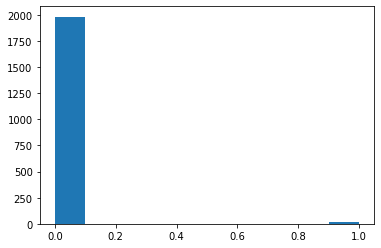

In [23]:
print(plt.hist((history[:,3] - history[:,4])))